In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, sigma_clip

%matplotlib inline

file_path = '../ngc1087/hlsp_phangs-hst_hst_wfc3-uvis_ngc1087_f555w_v1_exp-drc-sci.fits'

In [2]:
img=fits.open(file_path)
unmasked_img_data=img[0].data
img_data = ma.masked_equal(unmasked_img_data, 0)

mean, median, std = sigma_clipped_stats(img_data)

np.sqrt(img_data.count()) # sqrt of number of unmasked pixels, gives side of square

4166.01104175205

In [3]:
img_details= img[0].header
img_details

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8000                                                  
NAXIS2  =                 8000                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
FILENAME= 'ngc1087_uvis_f555w_exp_drc_sci.fits' / name of file                  
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'WFC3  '          

In [4]:
ra_img_centre, dec_img_centre = img_details['CRVAL1'], img_details['CRVAL2']
pixel_centre=(img_details['CRPIX1'], img_details['CRPIX2'])

ra_img_centre, dec_img_centre, pixel_centre

(41.60216145, -0.49621823, (4000.5, 4000.5))

In [5]:
from astropy.wcs import WCS

# conversion from ra-dec to pixel
def radec_to_pixel(equi, img_details=img_details):
    w = WCS(img_details)
    # ra, dec = equi
    x, y = w.all_world2pix([equi], 1)[0]  # Using origin=1 for FITS standard
    return [x, y]

radec_to_pixel([ra_img_centre, dec_img_centre]) # should be equal to pixel_centre above

[4000.5, 4000.499999999681]

In [6]:
catalog_data=Table.read('../ngc1087/catalogs/hlsp_phangs-cat_hst_uvis_ngc1087_multi_v1_obs-human-cluster-class12.fits')
catalog_data

INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_F275W_VEGA,PHANGS_F275W_VEGA_ERR,PHANGS_F336W_VEGA,PHANGS_F336W_VEGA_ERR,PHANGS_F438W_VEGA,PHANGS_F438W_VEGA_ERR,PHANGS_F555W_VEGA,PHANGS_F555W_VEGA_ERR,PHANGS_F814W_VEGA,PHANGS_F814W_VEGA_ERR,PHANGS_F275W_mJy,PHANGS_F275W_mJy_ERR,PHANGS_F336W_mJy,PHANGS_F336W_mJy_ERR,PHANGS_F438W_mJy,PHANGS_F438W_mJy_ERR,PHANGS_F555W_mJy,PHANGS_F555W_mJy_TOT_ERR,PHANGS_F814W_mJy,PHANGS_F814W_mJy_TOT_ERR,PHANGS_NON_DETECTION_FLAG,PHANGS_NO_COVERAGE_FLAG,PHANGS_CI,CC_CLASS
,,,,,,deg,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,,,,
int64,int64,int64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7
1,6,6,3061,3940.42,1600.43,41.6028116852031,-0.5226213262640461,1.0,1,0.6,24.729494542215804,0.5998747139430656,23.88607494736099,0.21437045493146983,24.143625441175022,0.07588059223054137,23.492656317131793,0.037025545039364574,22.32521360255586,0.03227771702673194,0.00011373187082762904,6.290022541322113e-05,0.0003413579494655229,6.746591479797684e-05,0.0009068799985354495,6.344391844544782e-05,0.001466416954210719,5.005741243583675e-05,0.00283892918155533,8.448251453724083e-05,0.0,0.0,1.4182124742379356,outside
2,7,8,5072,3539.23,1688.12,41.60722718650146,-0.5216562472897812,1.0,1,1.0,24.757318687850532,0.5651493063547451,24.2790435676223,0.29017565633701753,24.49284347012641,0.1017707361136463,23.755156635268282,0.043636559721021984,22.491534553568922,0.03482292049867955,0.00011085429513736408,-5.775973427917381e-05,0.00023769638288205364,6.359061295983966e-05,0.0006574498217305569,6.168719043707294e-05,0.001151482510241463,4.6325201017063124e-05,0.0024357133617698983,7.819893398776592e-05,1.0,0.0,1.6066026738302206,outside
3,10,12,2660,4278.98,1781.64,41.59908549062943,-0.5206270092175895,1.0,2,0.9,22.524272105130322,0.0816345963154203,22.83876254035419,0.08775171490520828,23.130133331112468,0.034158571161636696,22.87852514800024,0.023884084701344486,22.422522929134825,0.03352645839357617,0.0008669043016227573,6.524614700830538e-05,0.0008956430987542928,7.246028856344841e-05,0.002306463931807728,7.263665336682568e-05,0.0025817247655115926,5.6849677629486497e-05,0.0025955585398866384,8.022837020732726e-05,0.0,0.0,1.538017492515106,outside
4,14,20,6939,4232.27,1901.58,41.59959958181611,-0.5193070033422237,1.0,2,0.9,25.046628883812488,0.7447471039938869,25.23736443918646,0.835680279026403,24.45952039299705,0.10466984803839134,23.91323124625074,0.050162410961592886,22.7329431179126,0.04361465900373821,8.492360985436327e-05,-5.8310495571456365e-05,9.833185324641178e-05,7.57606759183981e-05,0.0006779409112815442,6.542186180436407e-05,0.0009954684529407504,4.6037885263173544e-05,0.0019501263604570314,7.841600214261824e-05,1.0,0.0,1.6632927318250927,outside
5,18,25,7477,3859.1,1981.29,41.60370669313904,-0.5184297509765641,2.0,3,0.8,22.13097897301808,0.07153533183826698,22.45961778150143,0.07996028451061807,23.812204757377835,0.06678091601532117,23.774589625618244,0.05351980730173305,23.66996963889715,0.10963835438029923,0.0012453413564540918,8.213314818183132e-05,0.001269968320009201,9.362173408797762e-05,0.0012306033614493503,7.576697210294033e-05,0.0011310561089423214,5.580950283029834e-05,0.000822720169506304,8.316184495914028e-05,0.0,0.0,1.6780559487477467,ycl
6,19,27,6967,4188.02,2007.16,41.600086597977366,-0.5181450371453854,2.0,2,1.0,24.953693145455716,0.7562250070467109,25.30581300540107,0.8177428925866674,24.578940286527057,0.10919377601074155,23.869485576079317,0.04934351805560406,22.6698416265766,0.04134348621914523,9.251299518279796e-05,-6.45005234742164e-05,9.232403943791378e-05,6.960509632848094e-05,0.00060

In [7]:
cluster_equi_coord = np.array([catalog_data['PHANGS_RA'], catalog_data['PHANGS_DEC']]).T

cluster_pixels = [radec_to_pixel(equi_coord) for equi_coord in cluster_equi_coord]

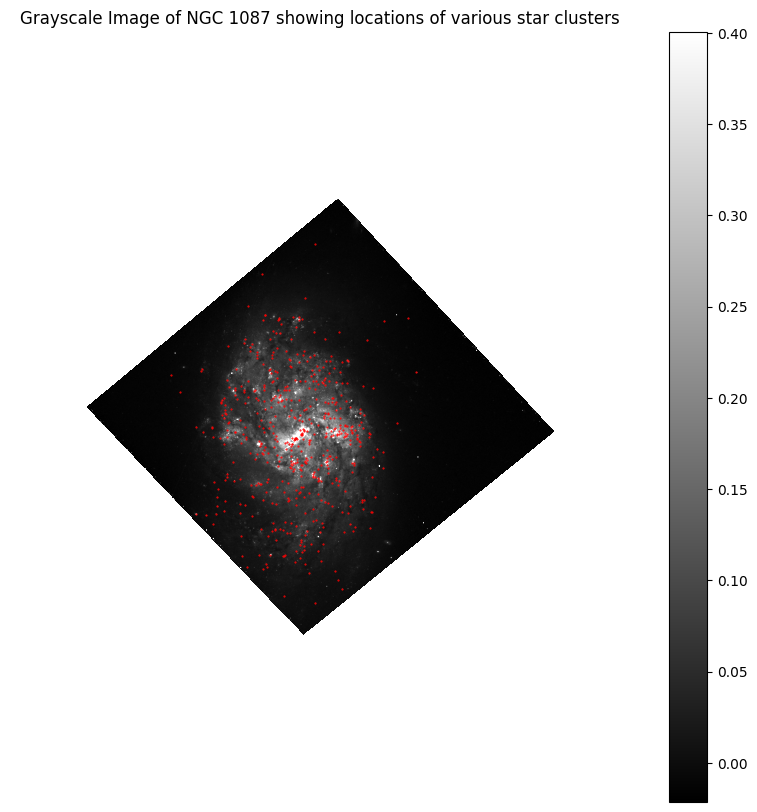

In [8]:
plt.figure(figsize=(10,10))

plt.imshow(img_data, vmin = mean-std, vmax = mean+15*std, cmap='gray', origin='lower')
plt.plot(*np.array(cluster_pixels).T, 'r.', markersize=1)
plt.title('Grayscale Image of NGC 1087 showing locations of various star clusters')
plt.colorbar()
plt.axis('equal')
plt.axis('off')
# plt.savefig('ngc1087_gray_with_clusters.png')
plt.show()

In [9]:
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry, ApertureStats

In [10]:
aperture=CircularAperture(cluster_pixels, r=4)
annulus_aperture = CircularAnnulus(cluster_pixels, r_in=7, r_out=8)

phot_table = aperture_photometry(img_data, aperture)

aperstats = ApertureStats(img_data, annulus_aperture)
bkg_mean = aperstats.mean

aperture_area = aperture.area_overlap(img_data)
phot_table['total_bkg'] = bkg_mean * aperture_area
phot_table['aperture_sum_bkgsub'] = phot_table['aperture_sum'] - phot_table['total_bkg']

phot_table

id,xcenter,ycenter,aperture_sum,total_bkg,aperture_sum_bkgsub
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,3941.4200000002456,1601.4300000005328,4.281682196317539,0.2514009813465497,4.030281214970989
2,3540.2300000000723,1689.1200000016765,3.7152274329911887,0.5268012280882891,3.1884262049028997
3,4279.980000000171,1782.6399999995797,7.621174020956251,0.43282006355903313,7.188353957397218
4,4233.26999999994,1902.580000000492,3.005112995778386,0.3526798420063227,2.6524331537720633
5,3860.099999999705,1982.2899999997667,4.437303032025351,1.4449165402504993,2.9923864917748517
6,4189.019999999878,2008.1600000002566,3.269845173975521,0.7796980219263584,2.490147152049163
7,3267.370000000349,2038.9700000004227,3.8587053021896582,1.0288299178422442,2.829875384347414
8,3319.879999999883,2062.560000000395,4.784447455410304,0.9825631241211464,3.8018843312891577


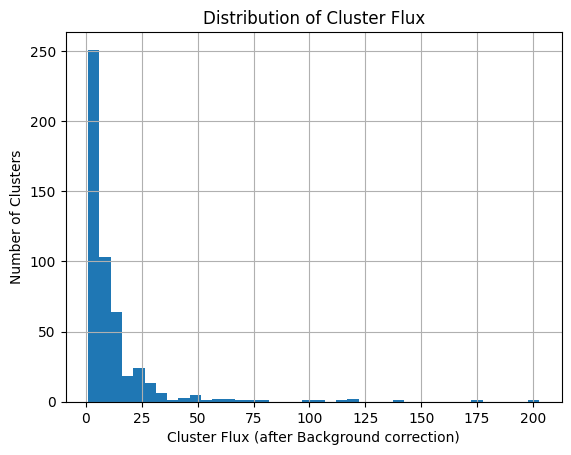

In [11]:
plt.hist(phot_table['aperture_sum_bkgsub'], bins=40)
plt.xlabel("Cluster Flux (after Background correction)")
plt.ylabel("Number of Clusters")
plt.title("Distribution of Cluster Flux")
plt.grid()
# plt.savefig('HistDistributionOfClusterFlux.png')
plt.show()

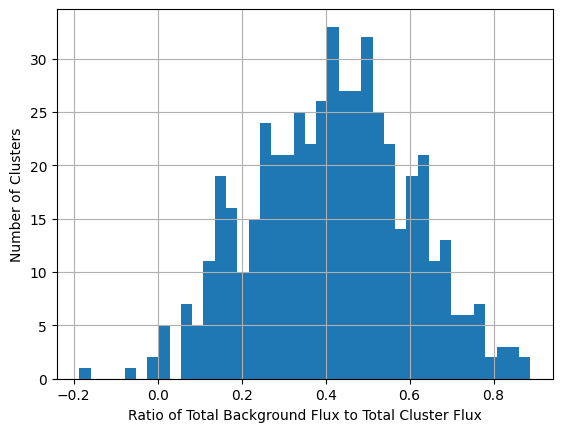

In [12]:
plt.hist(phot_table['total_bkg']/phot_table['aperture_sum'], bins=40)
plt.xlabel("Ratio of Total Background Flux to Total Cluster Flux")
plt.ylabel("Number of Clusters")
plt.grid()
# plt.savefig('HistRatioTotalBkgFluxToClusterFlux.png')
plt.show()

In [13]:
from astroquery.esasky import ESASky
from astropy.coordinates import SkyCoord
import astropy.units as u

result = ESASky.query_region_catalogs(position=SkyCoord(ra=ra_img_centre, dec=dec_img_centre, unit=(u.deg, u.deg)), radius=8*u.arcmin, catalogs="HSC", row_limit=40000)

result[0]

abs_corr,ci,ci_sigma,dsigma,extinction,htmid,kron_radius,kron_radius_sigma,num_filters,num_visits,spectrum_flag,start_mjd,start_time,stop_mjd,stop_time,x,y,z,match_id,target_name,num_images,num_images_per_filter,ra,dec,filter,flux,flux_sigma
,,,milliarcseconds,ABMag,,arcseconds,arcseconds,,,,MJD,time,MJD,time,,,,,,,,deg,deg,,mag,mag
object,float64,float64,float64,float64,int64,float64,float64,int32,int32,object,float64,object,float64,object,float64,float64,float64,int64,object,int32,int32,float64,float64,object,float64,float64
Y,2.344772761518305,0.0,0.0,0.04072757065296173,8935191551598,0.32679998874664307,0.0,1,1,N,57072.9218966458,2015-02-19 22:07:31.873,57072.98129496304,2015-02-19 23:33:03.887,0.7463523333953926,0.6654811310065439,-0.009646694238956494,47784180,SDSSJ024656.39-003304.8,1,1,41.72162412209072,-0.5527234389930289,w3_f606w,24.876399993896484,0.0
